# Project 1: Multiclass Classification on EUROSAT

Welcome to your first project *Multiclass Classification on EUROSAT*! This notebook will guide you through elementary steps that need to be taken in many machine learning projects.

Submissions for Project 1 are due on **November 20th** via your group's folder in Stud.IP (please find more details towards the end of this notebook).

1. Execute the following code to import required packages.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
#from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow import keras

## 1.1 Before Training

### Loading the data

2. Load the dataset ```EUROSAT``` in the version ```2.0.0```. To that end, call the function ```tfds.load``` only once and such that it returns a list ```[train_ds, val_ds, test_ds]``` as well as an object ```info``` of type ```tfds.core.DatasetInfo```. As a result, ```train_ds``` shall contain the first ```80%``` of the training split, ```val_ds``` shall contain the next ```10%``` of the training split, and ```test_ds``` shall contain the last ```10%``` of the training split of ```EUROSAT```.

Useful information can be found under https://www.tensorflow.org/datasets/catalog/eurosat and https://www.tensorflow.org/datasets/overview.

In [2]:
ds, info = tfds.load('EUROSAT',split=['train[90%:]','train[:80%]','train[80%:90%]'],with_info=True,as_supervised=True)
[test_ds,train_ds,val_ds]= ds


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteVYOGR3/eurosat-train.tfrecord*...:   0%|          …

Dataset eurosat downloaded and prepared to ~/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


The loaded datasets ```train_ds```, ```val_ds``` and ```test_ds``` are objects of type ```tensorflow.data.Dataset``` (or of a derived class). Moreover, ```info``` is an object of type ```tfds.core.DatasetInfo``` that contains useful information about the loaded data. In the following, you will first take a closer look at ```info```. Afterwards, you will learn how to access dataset items.

### Looking at the big picture

Use ```info``` to get a rough overview about ```EUROSAT```. Each ```item``` contained in ```train_ds```, ```val_ds``` and ```test_ds``` is a ```dictionary``` with keys ```"image"``` and ```"label"```.

3. Print the following information in the specified order:
   - Image shape (shape of ```item["image"]```)
   - Label shape (shape of ```item["label"]```)
   - Number of classes
   - Class names
   - Number of training examples

All these information can be extracted from ```info```. Do **not** use ```train_ds```, ```val_ds``` or ```test_ds``` directly. Print the first information using ```print("Image shape: {}".format(YOUR_CODE))``` and proceed analogously in the other cases.

In [3]:


print(info.features["image"].shape)
print(info.features["label"].shape)
print(info.features["label"].num_classes)
print(info.features["label"].names)
print(info.splits["train"].num_examples)


(64, 64, 3)
()
10
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
27000


**Checkpoint**: Your code should produce the following output.

```
Image shape: (64, 64, 3)
Label shape: ()
Number of classes: 10
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of training examples: 27000
```

Next, we will display a subset of the loaded images.

4. Use the function ```tfds.show_examples``` with optional arguments ```rows=2``` and ```cols=5```, to display ten items from ```train_ds```.

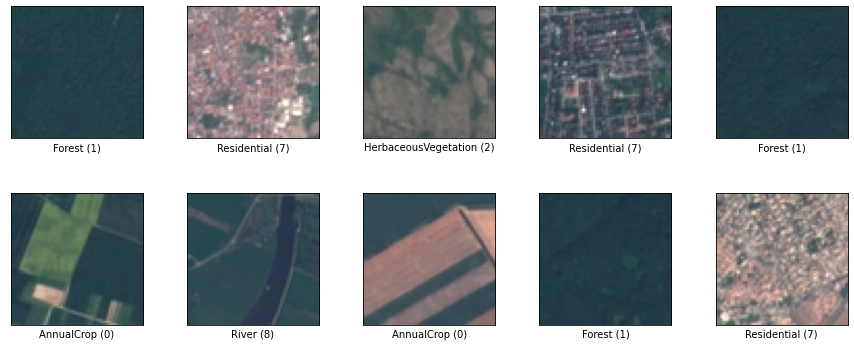

In [4]:
fig = tfds.show_examples(train_ds,info,rows=2,cols=5)

We do already know the number of elements in the full ```EUROSAT``` dataset. However, we subdivided the original training split into training, validation and test data. Moreover, we do not know how many items from which class are in the respective subsets.

5. Write a function ```count_occurences``` that takes as input a dataset ```ds``` and an object ```info```, and returns an array ```num_occurences```. Therein, ```num_occurences[i]``` represents the number of elements with ```item["label"] = i``` in ```ds```.

You can iterate over all elements in ```ds``` using a loop in the form of ```for item in ds: ...```.

In [5]:
def count_occurences(ds,info):
  num_occurences=np.zeros(10,dtype = np.int32)
  for item in ds:
    num_occurences[item[1].numpy()]+=1
    
  return num_occurences


6. Apply your function to ```train_ds```, ```val_ds``` und ```test_ds``` and print the frequencies of occurence of all classes in the respective datasets. Use
```python
train_occurences = YOUR_CODE
print("train_ds:\t {}".format(train_occurences))
```
for the first output, and format the other two accordingly.

In [6]:
train_occurences = count_occurences(train_ds,info)
print("train_ds:\t {}".format(train_occurences))
val_occurences = count_occurences( val_ds,info)
print("val_ds:\t\t {}".format(val_occurences))
test_occurences = count_occurences(test_ds,info)
print("test_ds:\t {}".format(test_occurences))

train_ds:	 [2427 2425 2379 1996 1999 1603 1996 2392 1989 2394]
val_ds:		 [297 289 304 252 244 206 237 298 266 307]
test_ds:	 [276 286 317 252 257 191 267 310 245 299]


**Checkpoint:** Your code should produce the following output.

```
train_ds:	 [2427 2425 2379 1996 1999 1603 1996 2392 1989 2394]
val_ds:		 [297 289 304 252 244 206 237 298 266 307]
test_ds:	 [276 286 317 252 257 191 267 310 245 299]
```

The number of elements in a dataset can alternatively be accessed via the method ```tensorflow.data.Dataset.cardinality```.

Finally, let us get an idea of the range of values of the loaded images.

7. Print the data format ```item["image"].dtype``` as well as the smallest and largest entry of an arbitrary element ```item``` from ```train_ds```. Format the output analogous to above.

By calling ```train_ds.take(1)``` you obtain a new dataset of type ```tensorflow.data.Dataset``` that contains only one item from ```train_ds```. The functions ```np.min``` and ```np.max``` can be helpful in order to compute the smallest and largest entries of an image. Although ```item["image"]``` is a tensor, you can apply ```numpy``` functions directly to it. In case you ever want to cast ```item["image"]``` (or any other tensor) explicitly as a ```numpy``` array (which does not apply here), the method ```item["image"].numpy()``` is for you.

In [7]:
single_item= train_ds.take(1)
for item in single_item:
    maxi= np.max(item[0].numpy())
    mini= np.min(item[0].numpy())
    
    print("largest entry:\t {}".format(maxi))
    print("smallest entry:\t {}".format(mini))

largest entry:	 98
smallest entry:	 26


### Preprocessing the data
In the previous step we have seen that the data are in integer format with entries in the range $\{0,\dots,255\}$ (well, we actually only looked at a single image, but a look at the entire dataset would reveal that this is true). In terms of a training algorithm to be used later, it is often advantageous to rescale the data to a smaller interval. Now, we will rescale all images from ```train_ds```, ```val_ds``` und ```test_ds``` to the range $[0, 1]$ through division by $255$. At the same time, we will transform all elements ```item``` from a ```dictionary``` to a tuple ```(item["image"] / 255, item["label"])```.

8. Write a function ```preprocess``` that takes as input an element ```item``` and returns a tuple as described above.

In [8]:
def preprocess(image,label):
    return (tf.cast(image, tf.float32) / 255, label)

9. Transform the datasets ```train_ds```, ```val_ds``` und ```test_ds``` using your function ```preprocess```. One call ```ds = ds.map(preprocess)``` is enough to transform a full dataset.

In [9]:
[test_ds, train_ds, val_ds]= ds

train_ds= train_ds.map(preprocess)
test_ds= test_ds.map(preprocess)
val_ds= val_ds.map(preprocess)

The class ```tf.data.Dataset``` provides various methods that can simplify the transformation of single items or entire datasets drastically. Two such methods are the above-mentioned ```tf.data.Dataset.take```, which requires an argument ```count``` and returns a new dataset including the first ```count``` elements of the calling dataset, as well as ```tf.data.Dataset.map```, which requires a function ```preprocess``` as input and applies this function automatically to all items in the dataset.

Further methods from ```tf.data.Dataset```, which we will now use to construct an **input pipeline**, are
- ```tf.data.Dataset.repeat``` to repeat a dataset a certain number of times,
- ```tf.data.Dataset.shuffle``` to shuffle the items of a dataset randomly,
- ```tf.data.Dataset.batch``` to group items of a dataset in batches of a certain size,
- ```tf.data.Dataset.prefetch```.

The usage of ```tf.data.Dataset``` is particularly efficient because only a fraction of the entire dataset is kept in the working memory at each time during training. Required data are loaded sequentially from disk into working memory and preprocessed. The method ```prefetch``` takes care that a specific number of batches will always be buffered ahead of time in the working memory. This prevents delays during training that could be caused by data loading and preprocessing. Further information can be found under https://www.tensorflow.org/api_docs/python/tf/data/Dataset.

10. Define ```batch_size = 32``` (will be needed in the next step). Then, apply the methods ```repeat``` (without argument), ```shuffle``` (with arguments ```buffer_size=1024``` and ```seed=0```), ```batch``` (with argument ```batch_size=batch_size```) and ```prefetch``` (with argument ```buffer_size=1```) to ```train_ds``` (in the specified order).

In [10]:
# your code
batch_size= 32
train_ds= train_ds.repeat()
train_ds= train_ds.shuffle(buffer_size= 1024, seed= 0)
train_ds= train_ds.batch(batch_size= batch_size)
train_ds= train_ds.prefetch(buffer_size= 1)

11. Execute the follwing code:

(32, 64, 64, 3)


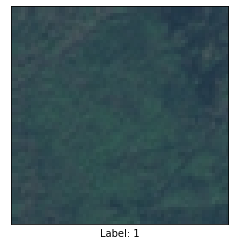

In [11]:
for item in train_ds.take(1):
    print(item[0].shape)
    plt.imshow(item[0][0, ...], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f'Label: {item[1][0]}')
    plt.show()

**Checkpoint:** You should get as output ```(32, 64, 64, 3)``` as well as (on first execution) an image showing forest.

12. Transform ```val_ds``` and ```test_ds``` in the same way, only omit calls of ```repeat``` and ```shuffle``` (would be without effect here) and use ```batch_size=1``` in the case of ```test_ds```.

You can either put all these calls into one line of code per dataset, or use a new line for each transformation. Be aware that each above-mentioned method returns a new dataset, as opposed to modifying a dataset in place.

In [12]:
# your code
#val_ds.repeat()
#val_ds= val_ds.shuffle(buffer_size= 1024, seed= 0)
val_ds= val_ds.batch(batch_size= batch_size)
val_ds= val_ds.prefetch(buffer_size= 1)

test_ds= test_ds.batch(batch_size= 1)
test_ds= test_ds.prefetch(buffer_size= 1)

## 1.2 Training phase

Now that inspection and preprocessing of the data are finished, we will use ```tensorflow.keras``` to define a first neural network model and train that model on the ```EUROSAT``` data.

### Model definition

13. Use the Keras Sequential API to define a *fully connected* model ```model``` featuring the following architecture:

 - One (parameter-free) input layer to vectorize the input data,
 - one hidden layer with 256 neurons and ReLU activation function,
 - one output layer with a suitable number of neurons and softmax activation function.

    
Helpful information can be found under https://www.tensorflow.org/api_docs/python/tf/keras/Sequential/. Regarding the input layer, use ```keras.layers.Flatten()``` and submit the argument ```input_shape``` to inform the model about the input data format. To that end, you can use ```info.features["image"].shape``` again.

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=info.features["image"].shape),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation= 'softmax')
])


### Model summary

14. Use ```model.summary``` to display a summary of your model.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 256)               3145984   
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 3,148,554
Trainable params: 3,148,554
Non-trainable params: 0
_________________________________________________________________


**Checkpoint:** The end of the output of ```model.summary()``` should be as follows.

```
Total params: 3,148,554
Trainable params: 3,148,554
Non-trainable params: 0
```

### Training

15. Call ```model.compile``` to compile your model. Use the loss function ```keras.losses.sparse_categorical_crossentropy```, the optimizer ```keras.optimizers.Adam```, as well as the metric ```keras.metrics.sparse_categorical_accuracy```. Moreover, use a learning rate rate schedule to implement a learning rate decay from initially ```1e-4``` to eventually ```1e-8```. Be sure to set the argument ```decay_steps``` of the schedule appropriately. Useful information can be found under https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PolynomialDecay.

In [15]:
epochs =100
start_learning_rate=1e-4

scheduler = tf.keras.optimizers.schedules.PolynomialDecay(start_learning_rate, epochs * sum(train_occurences) // batch_size, 1e-8, power=1.0)

model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=scheduler), metrics=[keras.metrics.sparse_categorical_accuracy])


16. Call ```model.fit``` with return value ```history``` to train your model for 100 epochs (as indicated in the previous cell) on ```train_ds```. Use the argument ```steps_per_epoch``` to pass the number of batches that need to be processed in each epoch. This number corresponds to the sum of entries of ```train_occurences``` divided by ```batch_size``` (round up). Also pass validation data ```val_ds```.

In [16]:
history= model.fit(
    train_ds,
    epochs=100,
    steps_per_epoch= np.sum(train_occurences)//batch_size,
    validation_data=val_ds,
)

Epoch 1/100
675/675 [==============================] - 21s 31ms/step - loss: 1.8398 - sparse_categorical_accuracy: 0.3079 - val_loss: 1.7474 - val_sparse_categorical_accuracy: 0.3519
Epoch 2/100
675/675 [==============================] - 18s 27ms/step - loss: 1.6892 - sparse_categorical_accuracy: 0.3683 - val_loss: 1.6639 - val_sparse_categorical_accuracy: 0.3896
Epoch 3/100
675/675 [==============================] - 18s 27ms/step - loss: 1.6374 - sparse_categorical_accuracy: 0.3950 - val_loss: 1.6794 - val_sparse_categorical_accuracy: 0.3500
Epoch 4/100
675/675 [==============================] - 18s 27ms/step - loss: 1.6019 - sparse_categorical_accuracy: 0.4137 - val_loss: 1.5678 - val_sparse_categorical_accuracy: 0.4333
Epoch 5/100
675/675 [==============================] - 18s 27ms/step - loss: 1.5558 - sparse_categorical_accuracy: 0.4333 - val_loss: 1.6022 - val_sparse_categorical_accuracy: 0.4159
Epoch 6/100
675/675 [==============================] - 18s 27ms/step - loss: 1.5323 -

17. Save your model as ```my_first_model.h5```.

In [17]:
model.save('my_first_model.h5')

18. Execute the following code to load your model again (this can be helpful if you pause and want to continue later).

In [18]:
model= tf.keras.models.load_model('my_first_model.h5')
model


**Checkpoint:** You should have been able to save and load your model again.

### Learning curves

The return value of ```model.fit``` is an object ```history``` of type ```keras.callbacks.History```. This object features attributes ```history.history``` and ```history.params```. The former is a dictionary with keys ```"loss"```, ```"sparse_categorical_accuracy"```, ```"val_loss"```, and ```"val_sparse_categorical_accuracy"```. The associated values are lists containing the respective metrics computed towards the end of each epoch.

19. Construct an object ```history_frame``` of class ```pd.DataFrame``` from ```history.history```. Call ```history_frame.plot(figsize=(8, 5))``` and afterwards ```plt.show()```.

Write your code below the two lines at the top of the following cell. The usage of ```seaborn``` here only provides a standardized and relatively pleasing style and rendering of the plots.

<function matplotlib.pyplot.show(*args, **kw)>

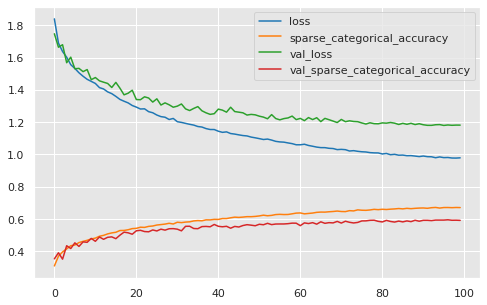

In [19]:
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_context('notebook')
history_frame= pd.DataFrame(data= history.history)
history_frame.plot(figsize=(8,5))
plt.show

### Model evaluation

During training, you could already watch the values of ```loss```, ```sparse_categorical_accuracy```, ```val_loss``` and ```sparse_categorical_val_accuracy``` evolve. To evaluate your model manually on a dataset, you can also call ```model.evaluate```.

20. Apply ```model.evaluate``` twice to evaluate your model on training and validation data.

In [20]:
model.evaluate(train_ds, steps=np.sum(train_occurences)//batch_size)
model.evaluate(val_ds)

85/85 [==============================] - 1s 10ms/step - loss: 1.1810 - sparse_categorical_accuracy: 0.5904


[1.1809799671173096, 0.5903703570365906]

***Congratulations!***

You have trained a first model for multiclass classification on ```EUROSAT``` and that is an important milestone!

## 1.3 After training

Apart from the model architecture and the observed metrics ```loss```, ```sparse_categorical_accuracy```, ```val_loss``` and ```val_sparse_categorical_accuracy```, we know yet only little about the functionality of our model. In this section, you will get to know two techniques for model visualization and interpretation.

### Forward propagation and model prediction

Before we proceed to a first visualization technique, we recapitulate the forward propagation of an input image through a fully connected neural network. For a model with one $\mathrm{ReLU}$ hidden layer and $\mathrm{softmax}$ output layer, the forward mapping can be written as follows.

$f(\mathbf x) = \underbrace{\mathrm{softmax}(\mathbf W^{[2]} \underbrace{\mathrm{ReLU}(\mathbf W^{[1]}\mathbf x + \mathbf b^{[1]})}_{\mathbf a^{[1]}} + \mathbf b^{[2]})}_{\mathbf a^{[2]}}$

As a first step, we will now compute $f(\mathbf x)$ using ```model```. The fastest way to do so is generally via the method ```model.predict```. However, just once, we will evaluate each layer of ```model``` separately to compute the network output. You can access the layers via ```model.layers[i]``` and use this object like a function. 

21. Complete the following code where indicated. The variable ```output``` shall ultimately contain $f(\mathbf x)$ while ```prediction``` shall be a single number representing the predicted class.

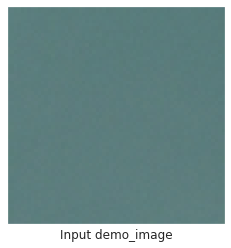

True label: 9

My Predicted Class Probabilities:

0: 0.00425
1: 0.00178
2: 0.00701
3: 0.00739
4: 0.00000
5: 0.13917
6: 0.00908
7: 0.00108
8: 0.00301
9: 0.82722

My Predicted label: 9
1/1 [==============================] - 0s 96ms/step

Model Predicted Class Probabilities:

0: 0.00425
1: 0.00178
2: 0.00701
3: 0.00739
4: 0.00000
5: 0.13917
6: 0.00908
7: 0.00108
8: 0.00301
9: 0.82722


In [21]:
# get one batch from train_ds and select first item
for item in train_ds.take(1):
    demo_image = item[0][:1, ...]
    demo_label = item[1][0]

from keras import backend as K

# compute hidden activations, model output and predicted_label
flattened_input = model.layers[0](demo_image) # your code
hidden_activations = model.layers[1](flattened_input) # your code
output = model.layers[2](hidden_activations) # your code
predicted_label = np.argmax(output.numpy())

 #max_index = output.index(max_value)
 #predicted_label = op.index(max_value) # your code
    
# plot demo_image, print demo_label
plt.imshow(demo_image[0, ...], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel('Input demo_image')
plt.show()
print(f'True label: {demo_label}\n')

# print my predicted class probabilities and demo_label
print('My Predicted Class Probabilities:\n')
for i in range(output.shape[1]):
    print(f'{i}: {output[0][i]:.5f}')
print(f'\nMy Predicted label: {predicted_label}')

# print model predicted class probabilities
model_output = model.predict(demo_image)
print('\nModel Predicted Class Probabilities:\n')
for i in range(model_output.shape[1]):
    print(f'{i}: {model_output[0][i]:.5f}')

**Checkpoint:** The values ```My Predicted Class Probabilities``` should be equal to ```Model Predicted Class Probabilities```. Moreover, the value ```My Predicted Label``` should correspond to the index of the largest entry of ```My Predicted Class Probabilities```.

### Interpretation of model predictions

Now that we have visualized the connection between model parameters and activations, we will implement another method to explain the relation between model input and prediction: *Layer-Wise Relevance Propagation* (LRP) computes one so-called relevance score per input pixel, which can be considered the contribution of that pixel to the model prediction. To that end, relevance scores for all neurons in the network are successively generated via backpropagation from the output layer to the input layer.

Relevance scores for the ouput layer are initially defined using the model output (i.e., the predicted probability) corresponding to ```predicted_label``` ($k$ represents the respective index here):

$\mathbf r^{[L]} := \begin{pmatrix}0\\\vdots\\\mathbf a^{[L]}_k\\\vdots\\0\end{pmatrix}\in \mathbb R^{n_L}$ 

Afterwards, relevance scores $\mathbf r^{[L-1]}, \mathbf r^{[L-2]}, \dots, \mathbf r^{[1]}, \mathbf r^{[0]}$ (in exactly this order) are computed for all other layers as follows:

$\displaystyle \mathbf r^{[\ell-1]} := \alpha \ \frac{\mathbf a^{[\ell -1]}\odot \mathbf W^{[\ell]\top+}}{\mathbf a^{[\ell -1]\top} \mathbf W^{[\ell]\top+}} \ \mathbf r^{[\ell]} \ - \ \beta \ \frac{\mathbf a^{[\ell -1]}\odot \mathbf W^{[\ell]\top-}}{\mathbf a^{[\ell -1]\top} \mathbf W^{[\ell]\top-}} \ \mathbf r^{[\ell]}$

Therein

$\mathbf W^{[\ell]\top+} := \max(\mathbf W^{[\ell]\top}, \mathbf 0)$

denotes the positive part and

$\mathbf W^{[\ell]\top-} := -\min(\mathbf W^{[\ell]\top}, \mathbf 0)$

denotes the negative part of $\mathbf W^{[\ell]\top} \in \mathbb R^{n_{\ell-1}\times n_{\ell}}$, where minimum and maximum are computed componentwise. Moreover, 

$\mathbf a^{[\ell -1]}\odot \mathbf W^{[\ell]\top+}\in \mathbb R^{n_{\ell-1}\times n_{\ell}}$

results from componentwise multiplication of $\mathbf a^{[\ell -1]}\in \mathbb R^{n_{\ell-1}}$ with each column of $\mathbf W^{[\ell]\top+}$ (same for the negative part). Analogously, the fraction line stands for componentwise division of the rows of $\mathbf a^{[\ell -1]}\odot \mathbf W^{[\ell]\top+}$ by $\mathbf a^{[\ell -1]\top} \mathbf W^{[\ell]\top+}\in \mathbb R^{1\times n_{\ell}}$ (same for the other fraction). Consequently, each fraction represents a $n_{\ell-1}\times n_{\ell}$ matrix which is then multiplied with $\mathbf r^{[\ell]}\in \mathbb R^{n_{\ell}\times 1}$.

The scalar values $\alpha, \beta \geq 0$ are chosen such that $\alpha - \beta = 1$. Therewith, it can be shown that

$\sum_j \mathbf r^{[L]}_j = \sum_j \mathbf r^{[L-1]}_j = \sum_j \mathbf r^{[L-2]}_j = \dots = \sum_j \mathbf r^{[1]}_j = \sum_j \mathbf r^{[0]}_j$

holds. Therefore, LRP has a so-called *relevance conservation property*.

The above formulas are kept as brief as possible. However, they have a concrete interpretation: Each neuron in a layer contributes positively or negatively to all neuron activations in successive layers. The relevance score of a neuron can be considered a proportionate sum of these contributions, and that is exactly reflected in the above formulas.

If you have questions regarding LRP or want to know more about it, join Question Time or have a look at https://www.sciencedirect.com/science/article/pii/S1051200417302385?via%3Dihub.

Here is your exercise:

22. Complete the following function at the positions indicated by ```None``` such that it fits exactly with the above LRP formula. Again, be aware that ```model.layers[l].weights[0]``` corresponds to $\mathbf W^{[\ell]\top}$. If you are unsure about shapes or dimensions of tensors, you can use ```tf.Tensor.shape``` to generate intermediate outputs. Also note that the function ```LRP``` should work for arbitrarily deep and wide fully connected $\mathrm{ReLU}$ networks with $\mathrm{softmax}$ output activation.

In [22]:

def lrp(alpha, beta, model, x):
    
    # get number of layers (including input layer)
    num_layers = len(model.layers)
    
    # get activations
    activations = [model.layers[0](x)]
    for l in range(1, num_layers):
        activations.append(model.layers[l](activations[-1]))
        
    # compute scores
    scores = [tf.transpose(activations[-1])]
    c = tf.squeeze(tf.math.argmax(scores[0]))
    for l in range(num_layers-2, -1, -1):
        w = model.layers[l+1].weights[0]
        if l == num_layers-2:
            w_pos = tf.clip_by_value(w[:, c:c+1], 0, np.inf)
            w_neg = -tf.clip_by_value(w[:, c:c+1], -np.inf, 0)
            s = scores[0][c:c+1]
            scores[0] = s
        else:
            w_pos = tf.clip_by_value(w, 0, np.inf)
            w_neg = -tf.clip_by_value(w, -np.inf, 0)
            s = scores[0]
        a = activations[l]
        
        # use the following mask_pos and mask_neg to prevent from division by zero when computing score_pos and score_neg
        mask_pos = tf.cast(tf.matmul(a, w_pos) == 0, tf.float32) + 1e-6
        mask_neg = tf.cast(tf.matmul(a, w_neg) == 0, tf.float32) + 1e-6
        score_pos = alpha * tf.matmul((tf.transpose(a)* w_pos)/(tf.matmul(a, w_pos)) , s) # your code
        score_neg = beta * tf.matmul((tf.transpose(a)*w_neg)/(tf.matmul(a, w_neg)),  s)# your code
        score_total =  (score_pos - score_neg )#score_pos - score_neg # your code
        scores.insert(0, score_total)
        
    return scores, activations

23. Apply LRP with $\alpha=2$ and $\beta=1$ to ```model``` and ```demo_image```.

Predicted Probability for Predicted Class (Relevance in Output Layer):

0.38758


Sum of all Relevances in Input Layer:

0.38758


True Class

3 (Highway)

1/1 [==============================] - 0s 17ms/step

Predicted Class

3 (Highway) with probability 0.38757801055908203



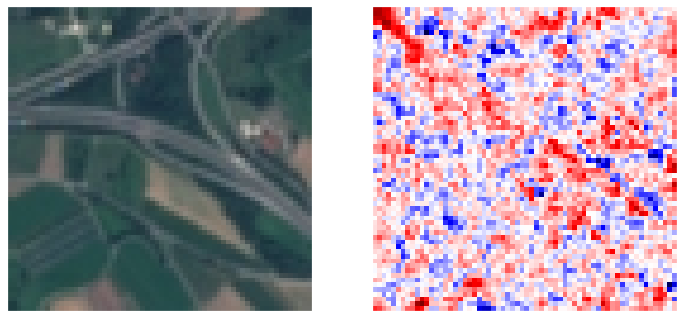

In [23]:
from tensorflow.python.ops.gen_nn_ops import relu
 #you can uncomment the following three lines to try demo_image / demo_label other than the above-defined
for item in train_ds.take(1):
  demo_image = item[0][:1, ...]
  demo_label = item[1][0]
#
scores,_= lrp(2, 1, model, demo_image) # your code
scores_input = scores[0].numpy().reshape(64, 64, 3)

print('Predicted Probability for Predicted Class (Relevance in Output Layer):\n')
print(f'{tf.squeeze(scores[-1]).numpy():.5f}\n')

print('\nSum of all Relevances in Input Layer:\n')
print(f'{tf.squeeze(tf.reduce_sum(scores[0])).numpy():.5f}\n')

print('\nTrue Class\n')
print(f'{demo_label} ({info.features["label"].names[demo_label]})\n')

prediction = model.predict(demo_image)
predicted_label = np.argmax(prediction)
print('\nPredicted Class\n')
print(f'{predicted_label} ({info.features["label"].names[predicted_label]}) with probability {prediction[0][predicted_label]}\n')

plt.subplots(1, 2, figsize=(12, 6.75))
plt.subplot(1, 2, 1)
plt.imshow(demo_image[0, ...], norm=mcolors.TwoSlopeNorm(vcenter=0.5))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
tmp = np.sum(scores_input, axis=2)
min_score = tmp.min()
max_score = tmp.max()
tmp = (tmp - min_score) / (max_score - min_score)
plt.imshow(tmp, cmap=plt.cm.seismic, norm=mcolors.TwoSlopeNorm(vcenter=-min_score / (max_score - min_score)), alpha=1.)
plt.xticks([])
plt.yticks([])
plt.show()

**Checkpoint**: Both displayed numbers should be equal if your implementation of LRP is correct (otherwise, your implementation does not obey the relevance conservation property).

### Hyperparameter Tuning

Your first model had only one hidden layer and a very small number of neurons. In this section, you will train many more models to find a configuration of *hyperparameters* that yield a much better performance on the validation data. Although there exist dedicated approaches and software to explore the space of hyperparameters, we will start with simple nested ```for``` loops. This is for certain not the most efficient among the available approaches, which is why you should carry out the following computation on the GPU-cluster. You may extend the hyperparameter configurations specified below to extend the search space.

24. Understand and complete the following code and discuss it with your teammate. Execute the code on the GPU-cluster.

In [24]:
results = pd.DataFrame(columns=['start_learning_rate', 'width', 'depth', 'l2_weight', 'train_loss', 'val_loss', 'train_acc', 'val_acc'])

start_learning_rates = [1e-5, 1e-4, 1e-3]
widths = [256, 512, 1024]
depths = [1, 2, 3]
l2_weights = [0, 1e-5, 1e-4]

for start_learning_rate in start_learning_rates:
    for width in widths:
        for depth in depths:
            for l2_weight in l2_weights:
                model = keras.models.Sequential()
                model.add(tf.keras.layers.Flatten(input_shape=info.features["image"].shape))# your code (add input layer)
                for _ in range(depth):
                    model.add(keras.layers.Dense(units=width, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_weight)))
                model.add(tf.keras.layers.Dense(10,activation='softmax'))# your code (add output layer)
                scheduler = tf.keras.optimizers.schedules.PolynomialDecay(start_learning_rate, epochs * sum(train_occurences) // batch_size, 1e-8, power=1.0)
                model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=scheduler), metrics=[keras.metrics.sparse_categorical_accuracy])
                model.fit(train_ds,epochs=100,steps_per_epoch= np.sum(train_occurences)//batch_size,validation_data=val_ds,verbose=0)# your code (call fit function with verbose=0)
                train_loss, train_acc = model.evaluate(train_ds, steps=np.sum(train_occurences) // batch_size)
                val_loss, val_acc = model.evaluate(val_ds)
                results_tmp = np.array([start_learning_rate, width, depth, l2_weight, train_loss, val_loss, train_acc, val_acc]).reshape(1, -1)
                results = results.append(pd.DataFrame(data=results_tmp, columns=results.columns), ignore_index=True)
results.to_csv('results.csv')

85/85 [==============================] - 2s 22ms/step - loss: 1.3414 - sparse_categorical_accuracy: 0.5441


KeyboardInterrupt: ignored

25. Load the file ```results.csv``` using Pandas and find out which hyperparameter configuration worked best. Train a model ```my_best_model``` using these hyperparameters and evaluate it on ```test_ds```. Apply LRP to at least ten images from ```test_ds``` and visualize the results.

In [ ]:
df = pd.read_csv('results.csv')
df

### Confusion matrix

The confusion matrix is a useful tool to evaluate your model's performance on each specific class rather than looking at an overall accuracy as above.

26. Make yourself familiar with the concept of the confusion matrix, complete and execute the code below using your ```my_best_model```. Discuss the results with your teammate. The information under https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix could be helpful.

In [25]:
def show_confusion_matrix(cm, labels):
  

  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()


2700/2700 [==============================] - 8s 3ms/step


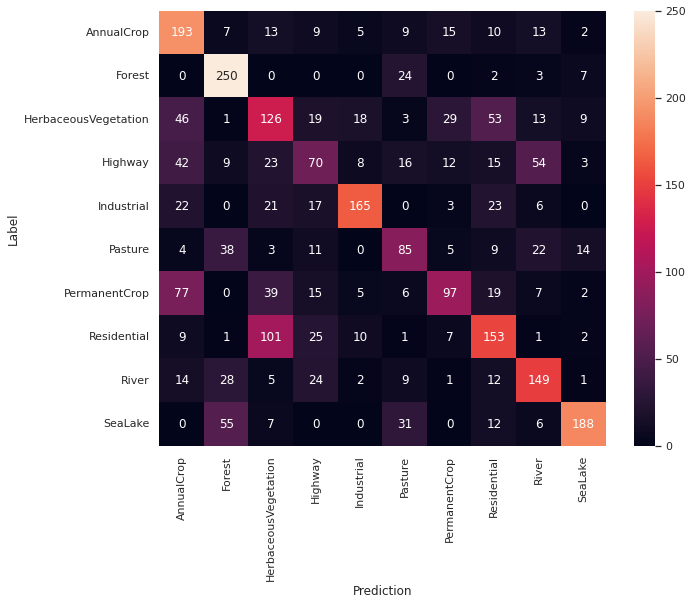

In [26]:
true_test_labels = list(test_ds.map(lambda x,y:y))#list()
#print(type(true_test_labels[0]))
predicted_test_labels = list(tf.argmax(model.predict(test_ds), axis = 1))
#for x,y in test_ds:
 # predicted_test_labels.append(np.argmax(model.predict(x)))
  #true_test_labels.append(y.numpy())
num_classes =len(info.features["label"].names)
#true_test_labels=np.array(true_test_labels)
#predicted_test_labels=np.array(predicted_test_labels)
confusion_mtx = tf.math.confusion_matrix(true_test_labels, predicted_test_labels, num_classes)
show_confusion_matrix(confusion_mtx, info.features["label"].names)

### Submission due on November 20th

27. Submit your completed notebook, your ```my_best_model.h5```, the files you used to carry out hyperparameter tuning on the cluster, and your ```results.csv``` via your group's folder in Stud.IP **not later than November 20th 2022**.